In [1]:
#! /usr/bin/env python

import os
from argparse     import ArgumentParser

from yaml import Loader, load

import numpy as np
from scipy import sparse
from scipy import odr
import pandas as pd
import bioframe as bf
from sklearn.metrics import v_measure_score, adjusted_rand_score

from matplotlib import pyplot as plt

import anndata as ad
import scanpy as sc
import muon as mu
#import scrublet as scr

import networkx as nx

from cutag.parsers.cellranger import load_cellranger, load_ADTs
from cutag.utilities.clustering import wanted_leiden
from cutag.stats.metrics import ragi_score

from threadpoolctl import threadpool_limits

/home/fransua/.miniconda3/envs/sc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def jacind(M1, M2, p=2, binarize=False):
    if binarize:
        M1 = (M1 > 0).astype(int)
        M2 = (M2 > 0).astype(int)
    M1 = np.squeeze(np.asarray(M1.todense()))
    M2 = np.squeeze(np.asarray(M2.todense()))
    d12 = ((abs(M1 - M2)**p).sum())**(1 / p)
    E = ((M1**p).sum() + (M2**p).sum())**(1 / p)
    return (E - d12) / E

def linear_func(p, x):
   m, c = p
   return m * x + c

def merge_adjacent_bins(adata):
    prevc, p = adata.var.index[0].split(':')
    prevb, preve = p.split('-')
    ns = []
    list_of_lists = []
    list_of_lists_idx = []
    for n, peak in enumerate(adata.var.index[1:]):
        c, p = peak.split(':')
        b, e = p.split('-')
        if b == preve and c == prevc:
            ns.append(n)
        else:
            list_of_lists.append(f"{prevc}:{prevb}-{preve}")
            list_of_lists_idx.append(ns + [n])
            prevc, prevb = c, b
            ns = []
        preve = e
    list_of_lists.append(f"{prevc}:{prevb}-{e}")
    list_of_lists_idx.append(ns + [n + 1])

    adata.X = adata.X.tocsc()  # this will speed up column peeking
    tmpX = adata.X.toarray()
    tmp = np.vstack([tmpX[:,idx].sum(axis=1) for idx in list_of_lists_idx]).T
    
    bdata = ad.AnnData(X=tmp, obs=adata.obs, dtype=tmp.dtype)
    bdata.var_names = list_of_lists

    return bdata

def normalize_TFIDF(adata, bgpath):
    # Get BG counts of genomic library
    process_line = lambda barcode, bg_count: (barcode, int(bg_count)) 
    bg_dict = dict(process_line(*l.split()) for l in open(bgpath, "r"))
    adata.obs["bg_counts"] = adata.obs.index.map(bg_dict)

    adata = merge_adjacent_bins(adata)
    # Normalize by TF-IDF
    N = len(adata.obs)
    ni = adata.X.sum(axis=0)
    Cij = adata.X
    Fj = adata.obs['bg_counts'].to_numpy()[:,None]

    adata.X = sparse.csr_matrix(
                    np.log(
                        (Cij / Fj) * (N / ni) * 10_000 + 1
                    )
                ).tocsc()  # this will speed up most computation
    # check!
    # print(adata.X.toarray().sum())


def normalize_CLR(ad_adts):
    """
    fancy way to divide by the total of each ADT accross cells
     -> to remove ADT specific bias
    """
    # compute geometric mean per ADT
    lna = np.log1p(ad_adts.X)  # we do the same as Satija
    n = lna.shape[0]
    geommeanADT = [np.exp(lna[:,i].sum() / n) for i in range(lna.shape[1])]

    # Normalize each ADT count by its geometric mean
    ad_adts.X /= geommeanADT

In [54]:
wnn = False  # set to False for faster analysis

sampleID = "1019"

data_dir = "/scratch2/shared/CUTAG/data/"

try:
    samples = load(open("/scratch2/shared/CUTAG/data/samples.yml"), Loader)[sampleID]
except KeyError:
    raise Exception(f'ERROR: {sampleID} not in sample YAML file')



dpath = os.path.join(data_dir, samples["modality"])

In [55]:
genomic_sample = os.path.join(dpath, sampleID)

adt_sampleID   = samples['ADT']
adt_sample     = os.path.join(dpath, adt_sampleID)
outdir         = 'lala'

regress_count  = "bg"
feature_type   = "peaks"
n_neighbors    = samples['optimal params']['n_neighbors']

seed           = None

min_cells      = samples['optimal params']['min_cells']
min_genes      = samples['optimal params']['min_genes']
max_genes      = samples['optimal params']['max_genes']
min_counts     = samples['optimal params']['min_counts']
max_counts     = samples['optimal params']['max_counts']

min_genes_adt  = samples['optimal params']['min_genes_adt']
min_counts_adt = samples['optimal params']['min_counts_adt']
max_counts_adt = samples['optimal params']['max_counts_adt']

if samples["modality"] == "CITE":
    max_mito    = samples['optimal params']['max_mito']
    min_n_genes = samples['optimal params']['min_n_genes']
    max_n_genes = samples['optimal params']['max_n_genes']    

n_leiden        = samples['optimal params']['n_leiden']

rm_pca          = samples['optimal params']['rm_pca']

n_pcs           = samples['optimal params']['n_pcs']
bg              = "bg"
normalize_total = True

In [56]:
# long long output directory name
dname = f"LEIDEN{n_leiden}_{sampleID}_MIN-CELLS{min_cells}"
dname += f"_MIN-GENES{min_genes}_MAX-GENES{max_genes}"
dname += f"_MIN-COUNTS{min_counts}_MAX-COUNTS{max_counts}_PCA{rm_pca}"
dname += f"_NPCS{n_pcs}_NEIGHB{n_neighbors}_REGRESS-{regress_count}"
if seed is not None:
    dname += f"_SEED{seed}"
outdir          = os.path.join(outdir, dname)

if os.path.exists(os.path.join(outdir, f"{sampleID}.h5mu")):
    print('Skipped...')
    exit()

print(f"Processing {sampleID}")

# Load data
### remove windows with less than five counts and then merge adjacent windows
print(f" - Loading Genomic library")
if samples["modality"] == "CITE":
    adata = sc.read(os.path.join(genomic_sample, "CITE_rna.h5ad"))
else:
    adata = load_cellranger(genomic_sample, feature_type=feature_type, 
                            dtype=float)

Processing 1019
 - Loading Genomic library


In [76]:
min_counts = 300

In [81]:
adata.n_obs

6134

In [78]:
log = f"Total cells: {adata.n_obs:,}\n"
log += f"Cells with less than {min_counts} counts: {sum(sc.pp.filter_cells(adata, min_counts=min_counts, inplace=False)[0]):,}\n"
log += f"Cells with more than {max_counts} counts: {sum(sc.pp.filter_cells(adata, max_counts=max_counts, inplace=False)[0]):,}\n"
log += f"Cells with less than {min_genes} features: {sum(sc.pp.filter_cells(adata, min_genes=min_genes, inplace=False)[0]):,}\n"
log += f"Cells with more than {max_genes} features: {sum(sc.pp.filter_cells(adata, max_genes=max_genes, inplace=False)[0]):,}\n"
log += f"Total features: {adata.n_vars:,}\n"
log += f"Features in less than {min_cells} cells: {sum(sc.pp.filter_genes(adata, min_cells=min_cells, inplace=False)[0]):,}\n"


In [79]:
print(log)

Total cells: 6,134
Cells with less than 300 counts: 2,308
Cells with more than 0 counts: 0
Cells with less than 200 features: 2,231
Cells with more than 0 features: 0
Total features: 17,283
Features in less than 20 cells: 15,530



In [15]:
# Filter bins in few cells
print(f" - Filter genomic features in few cells")
###########################################################################
# Filter Genomic library

# Cell barcodes with <1000 or >60000 UMIs
if min_counts:
    sc.pp.filter_cells(adata, min_counts=min_counts)
if max_counts:
    sc.pp.filter_cells(adata, max_counts=max_counts)

# # <50 or >700 genes detected
if min_genes:
    sc.pp.filter_cells(adata, min_genes=min_genes)
if max_genes:
    sc.pp.filter_cells(adata, max_genes=max_genes)
# removing genes expressed in fewer than 3 cells
if min_cells:
    sc.pp.filter_genes(adata, min_cells=min_cells)

# RNA specific filters
if samples["modality"] == "CITE":
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < max_mito, :]
    adata = adata[adata.obs.n_genes_by_counts > min_n_genes, :]
    adata = adata[adata.obs.n_genes_by_counts < max_n_genes, :]

 - Filter genomic features in few cells


In [16]:
adata

AnnData object with n_obs × n_vars = 2212 × 14081
    obs: 'n_counts', 'n_genes'
    var: 'n_cells'

In [7]:
###########################################################################
## BOOTSTRAPPING over Genomic features
#if seed:
#    mat = ad_hist.X.toarray()

#    np.random.seed(seed)

#    # Generate a list of 10 random numbers in the range [0, 250]
#    substitutes = np.random.choice(range(len(ad_hist)), int(len(ad_hist)), replace=True)

#    for i in range(len(substitutes)):
#        mat[:,i] = mat[:,substitutes[i]]

#    ad_hist.X = sparse.csr_matrix(mat)

###########################################################################
## GENOMIC PROCESSING
if samples["modality"] == "CITE":
    # Create a Scrublet object, fit the data to it and filter out predicted doublets
    print(f" - log(ygc /sc + 1) normalization on genomic library")
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata = adata[~predicted_doublets]
    L = adata.obs["total_counts"].sum()/len(adata)
    adata.obs["s"] = adata.obs["total_counts"]/L
    mat = adata.X.toarray()
    mat_div = mat/adata.obs["s"][:, np.newaxis]
    adata.X = mat_div # do not sum 1 because log1p already sums it
    sc.pp.log1p(adata)
else:
    # Normalize by TF-IDF
    print(f" - TF-IDF normalization on genomic library")
    normalize_TFIDF(adata, os.path.join(genomic_sample, "outs", 
                                        "mapped_read_per_barcode.txt"))

 - TF-IDF normalization on genomic library


In [8]:
###########################################################################
# Merge ADTS
print(f" - Loading ADTs")
print(os.path.join(adt_sample, "ADTs", "ADT_matrix.tsv"))
adts_file = os.path.join(adt_sample, "ADTs", "ADT_matrix.tsv")
# TODO: what is this?
if sampleID.startswith("GSM"):
    ad_adts = load_ADTs(adts_file, adata, modality= samples["modality"], transpose=True)
else:
    ad_adts = load_ADTs(adts_file, adata, modality= samples["modality"])

 - Loading ADTs
/scratch2/shared/CUTAG/data/scCUTnTAG-PRO/622/ADTs/ADT_matrix.tsv


In [9]:
###########################################################################
# Filter ADTs
print(f" - Filter ADTs with few counts")

if min_genes_adt:
    sc.pp.filter_cells(ad_adts, min_genes=min_genes_adt)

if min_counts_adt:
    sc.pp.filter_cells(ad_adts, min_counts=min_counts_adt)

if max_counts_adt:
    sc.pp.filter_cells(ad_adts, max_counts=max_counts_adt)

# WARNING: highly specific to Satija dataset:
if samples["lab"]=="Satija":
    ad_adts.obs.index = [f"{v[:-2]}-1" for v in ad_adts.obs.index]

 - Filter ADTs with few counts


In [10]:
###########################################################################
## BOOTSTRAPPING
if seed:
    mat = ad_adts.X

    np.random.seed(seed)

    # Generate a list of 10 random numbers in the range [0, 250]
    substitutes = np.random.choice(range(ad_adts.X.shape[1]), int(ad_adts.X.shape[1]), replace=True)
    mat2 = np.zeros(ad_adts.X.shape)

    for i in range(len(substitutes)):
        mat2[:,i] = mat[:,substitutes[i]]

    ad_adts.X = mat2

In [11]:
###########################################################################
# Merge ADT with genomic library
ad_adts.obs = pd.merge(ad_adts.obs, adata.obs, how="inner",
                       left_index=True, right_index=True)

In [12]:
###########################################################################
# Normalize each cell ADT count by the genomic-library background
if regress_count == "bg":
    if samples["modality"] == "CITE":
        ad_adts.obs["bg_counts"] = ad_adts.obs["total_counts"]
    else:
        if bg == "bg":
            process_line = lambda barcode, bg_count: (barcode, int(bg_count)) 
            bgpath = os.path.join(genomic_sample, "outs", "mapped_read_per_barcode.txt")
            bg_dict = dict(process_line(*l.split()) for l in open(bgpath, "r"))
            ad_adts.obs["bg_counts"] = ad_adts.obs.index.map(bg_dict)
        elif bg == "total_genomic":
            ad_adts.obs["bg_counts"] = adata.obs["n_counts"]
    print(f" - Normalize ADTs by genomic background")
    # Load the data
    x = np.log1p(np.sum(ad_adts.X, axis=1))
    y = np.log1p(ad_adts.obs["bg_counts"])
    # Create a model for fitting.
    linear_model = odr.Model(linear_func)
    # Create a RealData object using our initiated data from above.
    data = odr.RealData(x, y)
    # Set up ODR with the model and data.
    interp = odr.ODR(data, linear_model, beta0=[1., 1.])
    # Run the regression.
    out = interp.run()
    slope, intercept = out.beta
    ad_adts.obs["adt_count"] = np.sum(ad_adts.X, axis=1)
    ad_adts.obs["correction"] = intercept + slope * np.log1p(ad_adts.obs["adt_count"])
    # we apply correction on the log +1 of the X matrix, then come back to original values (with exp)
    ad_adts.X = np.exp(np.log1p(ad_adts.X) / ad_adts.obs["correction"].to_numpy()[:,None]) - 1

    # old shit
    # sc.pp.log1p(ad_adts)                                              # Eixo u a fet el Xavi
    # ad_adts.X /= np.log(ad_adts.obs["bg_counts"]).to_numpy()[:,None]  # Eixo u a fet el Xavi
    # ad_adts.X *= np.nanmedian(np.log(ad_adts.obs["bg_counts"]))       # Eixo u a fet el Xavi
    # ad_adts.X = np.exp(ad_adts.X)                                     # Eixo u a fet el Xavi
    # ad_adts.X = ad_adts.X - 1                                         # Eixo u a fet el Xavi
elif regress_count == "no":
    print(f" - no ADTs normalization by droplet")
else:
    raise NotImplementedError(
        f"ERROR: regression {regress_count} not implemented")

 - Normalize ADTs by genomic background


In [13]:
print(f" - Normalize ADTs by CLR")
normalize_CLR(ad_adts)

# scale data
if normalize_total == 1:
    sc.pp.normalize_total(ad_adts, target_sum=1_000_000)
    sc.pp.normalize_total(adata  , target_sum=1_000_000)

 - Normalize ADTs by CLR


In [14]:
###########################################################################
# ANALYSIS
###########################################################################
os.system(f"mkdir -p {outdir}")

# Merge with MUON
print(f" - Merge Genomic and ADT data into Muon object")
mdata = mu.MuData({"histone": adata, "ADT": ad_adts})

mdata.var_names_make_unique()
mu.pp.intersect_obs(mdata)

 - Merge Genomic and ADT data into Muon object


In [15]:
###########################################################################
# PCA
print(f" - Computing PCAs")
md_histones = mdata.mod["histone"]
md_membrane = mdata.mod["ADT"]

 - Computing PCAs


In [16]:
with threadpool_limits(limits=1, user_api='blas'):
    sc.tl.pca(md_membrane, svd_solver='arpack')
    sc.tl.pca(md_histones, svd_solver='arpack')

In [17]:
if rm_pca:
    md_histones.obsm['X_pca'] = md_histones.obsm['X_pca'][:,1:]

num_cells = len(md_histones.obs_names)
n_neighbors = int(np.sqrt(num_cells) * n_neighbors)

In [18]:
n_pcs = 50
n_neighbors

56

In [19]:
with threadpool_limits(limits=1, user_api='blas'):
    print(f" - Computing neighbors")
    sc.pp.neighbors(md_histones, n_pcs=n_pcs, n_neighbors=n_neighbors)
    sc.pp.neighbors(md_membrane, n_pcs=n_pcs, n_neighbors=n_neighbors)

 - Computing neighbors


In [20]:
print(f" - Leiden clustering histones ({n_leiden} wanted)")
md_histones = wanted_leiden(md_histones, n_leiden)
print(f" - Leiden clustering ADTs ({n_leiden} wanted)")
md_membrane = wanted_leiden(md_membrane, n_leiden)

 - Leiden clustering histones (5 wanted)
 - Leiden clustering ADTs (5 wanted)


In [21]:
vms = v_measure_score(md_membrane.obs['leiden'], md_histones.obs['leiden'])

In [22]:
ari = adjusted_rand_score(md_membrane.obs['leiden'], md_histones.obs['leiden'])

In [23]:
print(f" - V-meassure score: {vms}")
print(f" - Adjusted Randome score: {ari}")
v_measures = {}
v_measures['leiden'] = vms

print(f" - Plotting")
with threadpool_limits(limits=1, user_api='blas'):
    sc.tl.umap(md_histones)

 - V-meassure score: 0.002824805123539517
 - Adjusted Randome score: 0.002441361260863591
 - Plotting


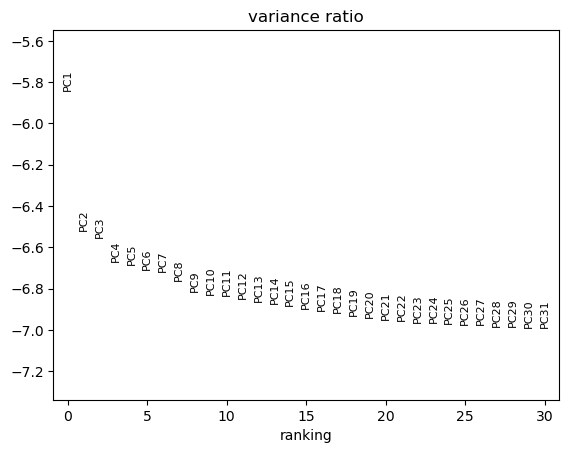

In [24]:
# plot PCA
sc.pl.pca_variance_ratio(md_histones, log=True, show=False)
plt.savefig(os.path.join(outdir, "genomic_pca-weights_plot.png"))

In [25]:
###########################################################################
# compute V-measure Score
adt_names = md_membrane.var_names

out = open(os.path.join(outdir, "V-measures.tsv"), "w")
out.write(f"leiden\t{v_measures['leiden']}\n")
# We classify cells according to their abundance for each of its ADTs
for col, adt in  enumerate(adt_names):
    # cells with a total number of ADT in the top  2% will be in cluster 7
    true_cluster  = (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col],  2)).astype(int)
    # cells with a total number of ADT in the top 25% will be in cluster 6
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 25)).astype(int)
    # cells with a total number of ADT in the top 50% will be in cluster 5
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 50)).astype(int)
    # cells with a total number of ADT in the top 70% will be in cluster 4
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 70)).astype(int)
    # cells with a total number of ADT in the top 85% will be in cluster 3
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 85)).astype(int)
    # cells with a total number of ADT in the top 95% will be in cluster 2
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 95)).astype(int)
    # cells with a total number of ADT in the top 98% will be in cluster 1
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 98)).astype(int)
    # cells with a total number of ADT in the bottom 2% will be in cluster 0

    obs_cluster = md_histones.obs["leiden"]
    # This classification is compared to the leiden 
    vms = v_measure_score(true_cluster, obs_cluster)
    v_measures[adt] = vms
    out.write(f"{col}\t{vms}\n")
out.close()

In [26]:
###########################################################################
# RAGIS
if samples["modality"] == "CITE":
    # Computing RAGI for CITE
    adata = mdata.mod["histone"]

    df = pd.DataFrame(adata.X, columns = ["".join(gene.split(":")[1:]) for gene in adata.var_names])

    df["leiden"] =  mdata.mod["ADT"].obs["leiden"].tolist()

    num_cells_cluster = mdata.mod["ADT"].obs["leiden"].value_counts().to_dict()

    bf_genes = bf.from_any(pd.read_csv(
        os.path.join(data_dir,'complementary_data/hg38_genes.tsv'), sep='\t'))

    # add info about housekeeping genes
    fh = open(os.path.join(data_dir,'complementary_data/Housekeeping_GenesHuman.csv'))
    next(fh)
    bf_genes['housekeeping'] = bf_genes['name'].isin(
        set([l.split(';')[1].strip() for l in fh]))

    marker_genes = pd.read_csv(os.path.join(data_dir,'complementary_data/Cell_marker_Human.txt'), sep='\t')

    tissue = samples['tissue_type']
    tmp = set(marker_genes[(marker_genes['cell_type'   ] == 'Normal cell') & 
                            (marker_genes['tissue_type'] == tissue) & 
                            (marker_genes['Symbol'] > '')]['Symbol'])
    bf_genes[f'marker {tissue}'] = bf_genes['name'].isin(tmp)

    # Remove from HK and from markers genes that are in both categories
    tmp = [False] * len(bf_genes)
    tmp |= (bf_genes['housekeeping']) & (bf_genes[f'marker {tissue}'])
    bf_genes.loc[tmp, f'marker {tissue}'] = False
    bf_genes.loc[tmp, 'housekeeping'] = False

    print(f"    => {sum(bf_genes[f'marker {tissue}'])} marker genes in {tissue}, ")
    print(f"    => {sum(bf_genes['housekeeping'])} housekeeping genes in {tissue}, ")

    df = df.groupby("leiden").sum()

    # iterate over rows and divide "MAFIP" by dictionary value
    for index, row in df.iterrows():
        df.loc[index] = row / num_cells_cluster[index]

    fun_genes = bf_genes['housekeeping'].copy()
    fun_genes |= bf_genes[f'marker {tissue}']

    ragis=dict()

    for gene in bf_genes[(bf_genes["marker Peripheral blood"] == True) | (bf_genes["housekeeping"] == True)]["name"]:
        try:
            ragis[gene] = gini(df[gene].to_numpy())
        except:
            print("")

    bf_genes['ragi'] = bf_genes['name'].map(ragis)
    bf_genes[fun_genes].to_csv(os.path.join(outdir, "RAGI_scores.tsv"), sep='\t')
else:
    # Computing RAGI for ASAP or CUTandTAG-PRO
    print(" - Computing RAGI")
    bf_genes = bf.from_any(pd.read_csv(
        os.path.join(data_dir,'complementary_data/hg38_genes.tsv'), sep='\t'))

    # add info about housekeeping genes
    fh = open(os.path.join(data_dir,'complementary_data/Housekeeping_GenesHuman.csv'))
    next(fh)
    bf_genes['housekeeping'] = bf_genes['name'].isin(
        set([l.split(';')[1].strip() for l in fh]))

    marker_genes = pd.read_csv(os.path.join(data_dir,'complementary_data/Cell_marker_Human.txt'), sep='\t')

    tissue = samples['tissue_type']
    tmp = set(marker_genes[(marker_genes['cell_type'   ] == 'Normal cell') & 
                            (marker_genes['tissue_type'] == tissue) & 
                            (marker_genes['Symbol'] > '')]['Symbol'])
    bf_genes[f'marker {tissue}'] = bf_genes['name'].isin(tmp)

    # Remove from HK and from markers genes that are in both categories
    tmp = [False] * len(bf_genes)
    tmp |= (bf_genes['housekeeping']) & (bf_genes[f'marker {tissue}'])
    bf_genes.loc[tmp, f'marker {tissue}'] = False
    bf_genes.loc[tmp, 'housekeeping'] = False

    print(f"    => {sum(bf_genes[f'marker {tissue}'])} marker genes in {tissue}, ")
    print(f"    => {sum(bf_genes['housekeeping'])} housekeeping genes in {tissue}, ")

    ###########################################################################
    # RAGI on ADTs
    fragments_path = os.path.join(genomic_sample, 'outs', 'fragments.tsv')

    fun_genes = bf_genes['housekeeping'].copy()
    fun_genes |= bf_genes[f'marker {tissue}']
    ragis = ragi_score(fragments_path, md_membrane, bf_genes[fun_genes], offset=10_000, clustering="leiden")
    bf_genes['ragi'] = bf_genes['name'].map(ragis)
    bf_genes[fun_genes].to_csv(os.path.join(outdir, "RAGI_scores.tsv"), sep='\t')

 - Computing RAGI
    => 57 marker genes in Tonsil, 
    => 2130 housekeeping genes in Tonsil, 
    - loading fragments
    - preprocessing -> gene score
    - Getting GINI of Gene scores -> RAGI


/scratch2/shared/software/cutag/cutag/stats/metrics.py:124: RuntimeWarning: invalid value encountered in double_scalars
  return sum(abs(xi - xj) for xi, xj in permutations(tmp, 2)) / (2 * n**2 * av)


In [44]:
bf_genes

,Unnamed: 0,chrom,start,end,name,housekeeping,marker Tonsil,ragi
0,0,chrY,8280198,8280198,TSPY24P,False,False,NaN
1,1,chrY,7854876,7854876,ZNF92P1Y,False,False,NaN
2,2,chrY,9621276,9621276,RBMY3AP,False,False,NaN
3,3,chrY,7809267,7809267,RFTN1P1,False,False,NaN
4,4,chrY,4802848,4802848,SERBP1P2,False,False,NaN
...,...,...,...,...,...,...,...,...
41347,61762,chr1,348366,348366,RPL23AP24,False,False,NaN
41348,61764,chr1,439870,439870,WBP1LP7,False,False,NaN
41349,61765,chr1,451678,451678,OR4F29,False,False,NaN
41350,61766,chr1,487101,487101,CICP7,False,False,NaN


In [45]:
bf_genes[fun_genes]

,Unnamed: 0,chrom,start,end,name,housekeeping,marker Tonsil,ragi
463,567,chr13,30617920,30617920,USPL1,True,False,0.151603
467,571,chr13,30465936,30465936,HMGB1,True,False,0.147641
481,589,chr13,49792682,49792682,KPNA3,True,False,0.125370
514,630,chr13,45120510,45120510,GTF2F2,True,False,0.200800
575,718,chr20,8019761,8019761,TMX4,True,False,0.105316
...,...,...,...,...,...,...,...,...
41155,61439,chr1,228082708,228082708,ARF1,True,False,0.132179
41194,61485,chr1,167553805,167553805,CREG1,True,False,0.064979
41209,61511,chr1,6785454,6785454,CAMTA1,True,False,0.180674
41327,61735,chr1,11262528,11262528,MTOR,True,False,0.371236


In [62]:
wnn = True

In [63]:
###########################################################################
# WNN
if wnn:
    with threadpool_limits(limits=1, user_api='blas'):
        print(1)
        mu.pp.neighbors(mdata, key_added='wnn', n_neighbors=n_neighbors)
        print(2)
        wanted_leiden(mdata, n_leiden, neighbors_key='wnn', key_added='leiden_wnn')
        print(3)
        mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
        print(4)
        mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

1


/home/fransua/.miniconda3/envs/sc/lib/python3.10/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/fransua/.miniconda3/envs/sc/lib/python3.10/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/fransua/.miniconda3/envs/sc/lib/python3.10/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/home/fransua/.miniconda3/envs/sc/lib/python3.10/site-packages/pynndescent/pynndescent_.py:351: NumbaWarning: Cannot cac

2
3
4


/home/fransua/.miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fransua/.miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(



Done.


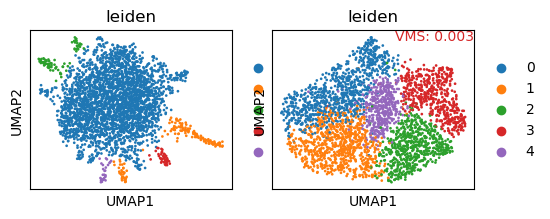

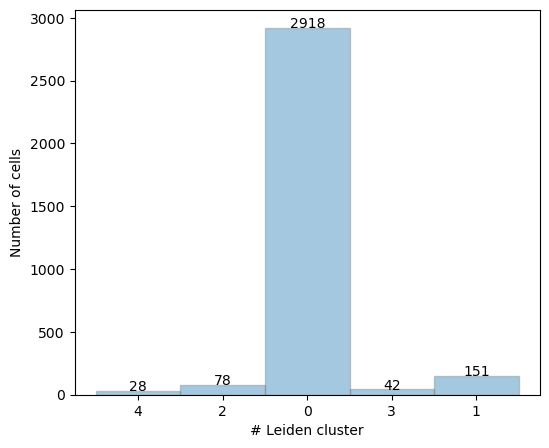

In [43]:
###########################################################################
# Summary plot
# scale ADT values for plotting
X = np.log1p(md_membrane.X)
minv = min([v for v in X.flatten() if v])
X[X==0] = minv
X -= minv
X /= max(X.flatten())
adts = pd.DataFrame(X, index=md_membrane.obs.index, columns=adt_names)
if samples["modality"] == "CITE":
    md_histones.obs = md_histones.obs[['n_counts', 'total_counts', 'leiden']] ###
else:
    md_histones.obs = md_histones.obs[['n_counts', 'bg_counts', 'leiden']] ###
md_histones.obs = pd.merge(md_histones.obs, adts, left_index=True, right_index=True, how="left")

_ = plt.figure(figsize=(12, 12))
axe = plt.subplot(5, 4, 1)
sc.pl.umap(md_histones, size=15, ax=axe, color="leiden", show=False)
axe = plt.subplot(5, 4, 2)
if wnn:
    sc.pl.umap(mdata, size=15, ax=axe, color='leiden_wnn', show=False)
else:
    sc.tl.umap(md_membrane, random_state=10)
    sc.pl.umap(md_membrane, size=15, ax=axe, color="leiden", show=False)
x = axe.get_xlim()[1]
y = axe.get_ylim()[1]
axe.text(x, y, f"VMS: {v_measures['leiden']:.3f}", va="top", ha="right", color="tab:red")
if wnn:
    axe = plt.subplot(5, 4, 3)
    mu.pl.embedding(mdata, basis="X_wnn_umap", color=["histone:leiden"], size=15, ax=axe, show=False)
    axe = plt.subplot(5, 4, 4)
    mu.pl.embedding(mdata, basis="X_wnn_umap", color="ADT:leiden", size=15, ax=axe, show=False)
#for n, col in enumerate([c for c in adt_names if not c.endswith("IgD")]):
#    axe = plt.subplot(5, 4, n + 5)
#    sc.pl.umap(md_histones, size=15, ax=axe, color=col, show=False, color_map="Greys", vmin=-0.1, vmax=1.1)
#    x = axe.get_xlim()[1]
#    y = axe.get_ylim()[1]
#    axe.text(x, y, f"VMS: {v_measures[col]:.3f}", va="top", ha="right", color="tab:red")
#plt.tight_layout()
#plt.savefig(os.path.join(outdir, "UMAP_on_V-measures.png"))

# Leiden numbers
_ = plt.figure(figsize=(6, 5))
h = plt.hist(md_histones.obs["leiden"], bins=n_leiden, 
             range=(-0.5, n_leiden - 0.5), ec="tab:grey", alpha=0.4)
for y, x in zip(h[0], h[1]):
    plt.text(x + 0.5, y, int(y), ha="center")
plt.ylabel("Number of cells")
plt.xlabel("# Leiden cluster")
plt.savefig(os.path.join(outdir, "Leiden_plot.png"))

out = open(os.path.join(outdir, "stats.tsv"), "w")
line = "\t".join(str(v) for v in h[0])
out.write(f"COUNT\t{line}\n")
out.write(f"TOTAL\t{sum(h[0])}\n")
out.write(f"STDEV\t{np.std(h[0])}\n")
out.close()

# save Muon object
#if seed==None:

#    print(f" - Save Muon object and stats")    
#    mdata.write_h5mu(os.path.join(outdir, f"{sampleID}.h5mu"))
#else:
#    if seed<6:
#        mdata.write_h5mu(os.path.join(outdir, f"{sampleID}.h5mu"))


mdata.write_h5mu(os.path.join(outdir, f"{sampleID}.h5mu"))

# compute jaccard index
M1 = mdata['histone'].obsp['connectivities']
M2 = mdata['ADT'].obsp['connectivities']

stat1 = jacind(M1, M2)
stat2 = jacind(M1, M2, binarize=True, p=1)

out = open(os.path.join(outdir, f"{sampleID}_stats.tsv"), "w")
out.write(f"VMS\t{vms}\n")
out.write(f"ARI\t{ari}\n")
out.write(f"JAC1\t{stat1}\n")
out.write(f"JAC2\t{stat2}\n")
out.close()

###########################################################################
# cells_clusters.csv
if wnn:
    mdata.obs[["histone:leiden","ADT:leiden","leiden_wnn"]].to_csv(os.path.join(outdir, "cells_clusters.csv"))
else:
    mdata.obs[["histone:leiden","ADT:leiden"]].to_csv(os.path.join(outdir, "cells_clusters.csv"))

print(f"\nDone.")

In [103]:
    dpath = os.path.join('/scratch2/shared/CUTAG/data/', samples["modality"])

    genomic_sample = os.path.join(dpath, sampleID)


In [104]:
    adt_sampleID   = samples['ADT']
    adt_sample     = os.path.join(dpath, adt_sampleID)
    outdir         = "/scratch2/shared/CUTAG/results11/"+sampleID
    
    regress_count  = "bg"
    feature_type   = "peaks"
    n_neighbors    = 1
    
    seed           = 1
    
    min_cells      = samples['optimal params']['min_cells']
    min_genes      = samples['optimal params']['min_genes']
    max_genes      = samples['optimal params']['max_genes']
    min_counts     = samples['optimal params']['min_counts']
    max_counts     = samples['optimal params']['max_counts']
    
    min_genes_adt  = samples['optimal params']['min_genes_adt']
    min_counts_adt = samples['optimal params']['min_counts_adt']
    max_counts_adt = samples['optimal params']['max_counts_adt']
    
    if samples["modality"] == "CITE":
        max_mito = samples['optimal params']['max_mito']
        min_n_genes = samples['optimal params']['min_n_genes']
        max_n_genes = samples['optimal params']['max_n_genes']    
    
    n_leiden       = samples['optimal params']['n_leiden']
    
    rm_pca         = samples['optimal params']['rm_pca']

    n_pcs          = samples['optimal params']['n_pcs']
    
    bg ="bg"
    
    # long long output directory name
    dname = f"LEIDEN{n_leiden}_{sampleID}_MIN-CELLS{min_cells}"
    dname += f"_MIN-GENES{min_genes}_MAX-GENES{max_genes}"
    dname += f"_MIN-COUNTS{min_counts}_MAX-COUNTS{max_counts}_PCA{rm_pca}"
    dname += f"_NPCS{n_pcs}_NEIGHB{n_neighbors}_REGRESS-{regress_count}"
    if seed is not None:
        dname += f"_SEED{seed}"
    outdir          = os.path.join(outdir, dname)

In [105]:
# if os.path.exists(os.path.join(outdir, f"{sampleID}.h5mu")):
#     print('Skipped...')
#     exit()

In [106]:
print(f"Processing {sampleID}")

# Load data
### remove windows with less than five counts and then merge adjacent windows
print(f" - Loading Genomic library")

if samples["modality"] == "CITE":
    adata = sc.read(os.path.join(genomic_sample, "CITE_rna.h5ad"))
else:
    adata = load_cellranger(genomic_sample, feature_type=feature_type, 
                          dtype=float)

Processing 946
 - Loading Genomic library


In [107]:
# Filter bins in few cells
print(f" - Filter genomic features in few cells")
###########################################################################
# Filter Histones

# Cell barcodes with <1000 or >60000 UMIs
if min_counts:
    sc.pp.filter_cells(adata, min_counts=min_counts)
    
if max_counts:
    sc.pp.filter_cells(adata, max_counts=max_counts)
    
# # <50 or >700 genes detected
if min_genes:
    sc.pp.filter_cells(adata, min_genes=min_genes)
    
if max_genes:
    sc.pp.filter_cells(adata, max_genes=max_genes)
    
# removing genes expressed in fewer than 3 cells
if min_cells:
    sc.pp.filter_genes(adata, min_cells=min_cells)

 - Filter genomic features in few cells


In [108]:
if samples["modality"] == "CITE":

    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < max_mito, :]
    adata = adata[adata.obs.n_genes_by_counts > min_n_genes, :]
    adata = adata[adata.obs.n_genes_by_counts < max_n_genes, :]

In [109]:
###########################################################################
## GENOMIC PROCESSING
if samples["modality"] == "CITE":
    # Create a Scrublet object, fit the data to it and filter out predicted doublets
    print(f" - log(ygc /sc + 1) normalization on genomic library")
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata = adata[~predicted_doublets]
    L = adata.obs["total_counts"].sum()/len(adata)
    adata.obs["s"] = adata.obs["total_counts"]/L
    mat = adata.X.toarray()
    mat_div = mat/adata.obs["s"][:, np.newaxis]
    adata.X = mat_div # do not sum 1 because log1p already sums it
    sc.pp.log1p(adata)
    
else:
    # Normalize by TF-IDF
    print(f" - TF-IDF normalization on genomic library")
    normalize_TFIDF(adata, os.path.join(genomic_sample, "outs", 
                                          "mapped_read_per_barcode.txt"))

 - TF-IDF normalization on genomic library


In [110]:
###########################################################################
# Merge ADTS
print(f" - Loading ADTs")
print(os.path.join(adt_sample, "ADTs", "ADT_matrix.tsv"))
adts_file = os.path.join(adt_sample, "ADTs", "ADT_matrix.tsv")
# TODO: what is this?
if sampleID.startswith("GSM"):
    ad_adts = load_ADTs(adts_file, adata, modality= samples["modality"], transpose=True)
else:
    ad_adts = load_ADTs(adts_file, adata, modality= samples["modality"])

 - Loading ADTs
/scratch2/shared/CUTAG/data/scCUTnTAG-PRO/947/ADTs/ADT_matrix.tsv


In [111]:
###########################################################################
# Filter ADTs
print(f" - Filter ADTs with few counts")

if min_genes_adt:
    sc.pp.filter_cells(ad_adts, min_genes=min_genes_adt)
    
if min_counts_adt:
    sc.pp.filter_cells(ad_adts, min_counts=min_counts_adt)
    
if max_counts_adt:
    sc.pp.filter_cells(ad_adts, max_counts=max_counts_adt)

# WARNING: highly specific to Satija dataset:
if samples["lab"]=="Satija":
    ad_adts.obs.index = [f"{v[:-2]}-1" for v in ad_adts.obs.index]

 - Filter ADTs with few counts


In [112]:
###########################################################################
## BOOTSTRAPPING
if seed:
    mat = ad_adts.X

    np.random.seed(seed)

    # Generate a list of 10 random numbers in the range [0, 250]
    substitutes = np.random.choice(range(ad_adts.X.shape[1]), int(ad_adts.X.shape[1]), replace=True)
    mat2 = np.zeros(ad_adts.X.shape)
    
    for i in range(len(substitutes)):
        mat2[:,i] = mat[:,substitutes[i]]

    ad_adts.X = mat2

In [113]:
###########################################################################
# Merge ADT with genomic library
ad_adts.obs = pd.merge(ad_adts.obs, adata.obs, how="inner",
                       left_index=True, right_index=True)

In [114]:
    ###########################################################################
    # Normalize each cell ADT count by the genomic-library background
    if regress_count == "bg":
        if samples["modality"] == "CITE":
            ad_adts.obs["bg_counts"] = ad_adts.obs["total_counts"]
        else:
            if bg == "bg":
                process_line = lambda barcode, bg_count: (barcode, int(bg_count)) 
                bgpath = os.path.join(genomic_sample, "outs", "mapped_read_per_barcode.txt")
                bg_dict = dict(process_line(*l.split()) for l in open(bgpath, "r"))
                ad_adts.obs["bg_counts"] = ad_adts.obs.index.map(bg_dict)
            elif bg == "total_genomic":
                ad_adts.obs["bg_counts"] = adata.obs["n_counts"]
        print(f" - Normalize ADTs by genomic background")
        # Load the data
        x = np.log1p(np.sum(ad_adts.X, axis=1))
        y = np.log1p(ad_adts.obs["bg_counts"])
        # Create a model for fitting.
        linear_model = odr.Model(linear_func)
        # Create a RealData object using our initiated data from above.
        data = odr.RealData(x, y)
        # Set up ODR with the model and data.
        interp = odr.ODR(data, linear_model, beta0=[1., 1.])
        # Run the regression.
        out = interp.run()
        slope, intercept = out.beta
        ad_adts.obs["adt_count"] = np.sum(ad_adts.X, axis=1)
        ad_adts.obs["correction"] = intercept + slope * np.log1p(ad_adts.obs["adt_count"])
        # we apply correction on the log +1 of the X matrix, then come back to original values (with exp)
        ad_adts.X = np.exp(np.log1p(ad_adts.X) / ad_adts.obs["correction"][:,None]) - 1
    
        # old shit
        # sc.pp.log1p(ad_adts)                                              # Eixo u a fet el Xavi
        # ad_adts.X /= np.log(ad_adts.obs["bg_counts"]).to_numpy()[:,None]  # Eixo u a fet el Xavi
        # ad_adts.X *= np.nanmedian(np.log(ad_adts.obs["bg_counts"]))       # Eixo u a fet el Xavi
        # ad_adts.X = np.exp(ad_adts.X)                                     # Eixo u a fet el Xavi
        # ad_adts.X = ad_adts.X - 1                                         # Eixo u a fet el Xavi
    elif regress_count == "no":
        print(f" - no ADTs normalization by droplet")
    else:
        raise NotImplementedError(
            f"ERROR: regrerssion {regress_count} not implemented")

 - Normalize ADTs by genomic background


/tmp/ipykernel_23223/2949314746.py:30: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ad_adts.X = np.exp(np.log1p(ad_adts.X) / ad_adts.obs["correction"][:,None]) - 1


In [119]:
np.exp(np.log1p(ad_adts.X) / ad_adts.obs["correction"].to_numpy()[:,None]) - 1

array([[0.06672263, 0.05920959, 0.13284666, ..., 0.0821715 , 0.06672263,
        0.05920959],
       [0.        , 0.0182717 , 0.02257899, ..., 0.01368788, 0.        ,
        0.0182717 ],
       [0.07038924, 0.10162456, 0.10195585, ..., 0.07046211, 0.07038924,
        0.10162456],
       ...,
       [0.        , 0.06001291, 0.01869288, ..., 0.        , 0.        ,
        0.06001291],
       [0.        , 0.0424228 , 0.01895537, ..., 0.        , 0.        ,
        0.0424228 ],
       [0.        , 0.05280795, 0.02405003, ..., 0.        , 0.        ,
        0.05280795]])

In [115]:
print(f" - Normalize ADTs by CLR")
normalize_CLR(ad_adts)

 - Normalize ADTs by CLR


In [83]:
# scale data
sc.pp.normalize_total(ad_adts, target_sum=1_000_000)
sc.pp.normalize_total(adata  , target_sum=1_000_000)

 - Merge Genomic and ADT data into Muon object
 - Computing PCAs
 - Computing neighbors
 - Leiden clustering histones (5 wanted)
 - Leiden clustering ADTs (5 wanted)
 - V-meassure score: 0.005726288946170267
 - Adjusted Randome score: -0.0030311530929974986
 - Plotting


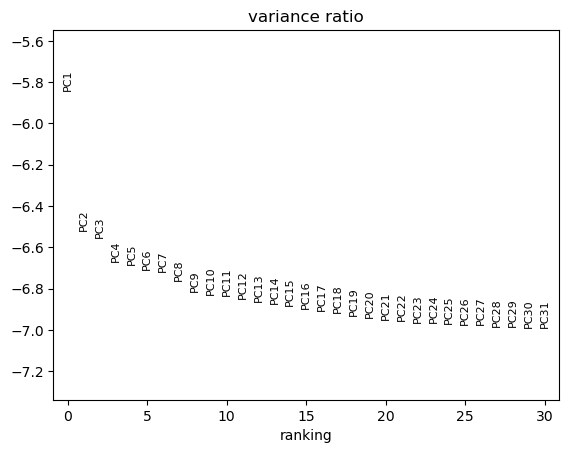

In [84]:
###########################################################################
# ANALYSIS
###########################################################################
os.system(f"mkdir -p {outdir}")

# Merge with MUON
print(f" - Merge Genomic and ADT data into Muon object")
mdata = mu.MuData({"histone": adata, "ADT": ad_adts})

mdata.var_names_make_unique()
mu.pp.intersect_obs(mdata)

###########################################################################
# PCA
print(f" - Computing PCAs")
md_histones = mdata.mod["histone"]
md_membrane = mdata.mod["ADT"]

sc.tl.pca(md_membrane, svd_solver='arpack')
sc.tl.pca(md_histones, svd_solver='arpack')
if rm_pca:
    md_histones.obsm['X_pca'] = md_histones.obsm['X_pca'][:,1:]

num_cells = len(md_histones.obs_names)
n_neighbors = int(np.sqrt(num_cells) * n_neighbors)

print(f" - Computing neighbors")
sc.pp.neighbors(md_histones, n_pcs=n_pcs, n_neighbors=n_neighbors)
sc.pp.neighbors(md_membrane, n_pcs=n_pcs, n_neighbors=n_neighbors)

print(f" - Leiden clustering histones ({n_leiden} wanted)")
md_histones = wanted_leiden(md_histones, n_leiden)
print(f" - Leiden clustering ADTs ({n_leiden} wanted)")
md_membrane = wanted_leiden(md_membrane, n_leiden)

vms = v_measure_score(md_membrane.obs['leiden'], md_histones.obs['leiden'])
ari = adjusted_rand_score(md_membrane.obs['leiden'], md_histones.obs['leiden'])
print(f" - V-meassure score: {vms}")
print(f" - Adjusted Randome score: {ari}")
v_measures = {}
v_measures['leiden'] = vms

print(f" - Plotting")
sc.tl.umap(md_histones)
# plot PCA
sc.pl.pca_variance_ratio(md_histones, log=True, show=False)
plt.savefig(os.path.join(outdir, "genomic_pca-weights_plot.png"))

In [85]:
###########################################################################
# compute V-measure Score
adt_names = md_membrane.var_names

out = open(os.path.join(outdir, "V-measures.tsv"), "w")
out.write(f"leiden\t{v_measures['leiden']}\n")
# We classify cells according to their abundance for each of its ADTs
for col, adt in  enumerate(adt_names):
    # cells with a total number of ADT in the top  2% will be in cluster 7
    true_cluster  = (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col],  2)).astype(int)
    # cells with a total number of ADT in the top 25% will be in cluster 6
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 25)).astype(int)
    # cells with a total number of ADT in the top 50% will be in cluster 5
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 50)).astype(int)
    # cells with a total number of ADT in the top 70% will be in cluster 4
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 70)).astype(int)
    # cells with a total number of ADT in the top 85% will be in cluster 3
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 85)).astype(int)
    # cells with a total number of ADT in the top 95% will be in cluster 2
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 95)).astype(int)
    # cells with a total number of ADT in the top 98% will be in cluster 1
    true_cluster += (md_membrane.X[:,col] <= np.percentile(md_membrane.X[:,col], 98)).astype(int)
    # cells with a total number of ADT in the bottom 2% will be in cluster 0

    obs_cluster = md_histones.obs["leiden"]
    # This classification is compared to the leiden 
    vms = v_measure_score(true_cluster, obs_cluster)
    v_measures[adt] = vms
    out.write(f"{col}\t{vms}\n")
out.close()

In [86]:
###########################################################################
if samples["modality"] == "CITE":
    adata = mdata.mod["histone"]

    df = pd.DataFrame(adata.X, columns = ["".join(gene.split(":")[1:]) for gene in adata.var_names])

    df["leiden"] =  mdata.mod["ADT"].obs["leiden"].tolist()

    num_cells_cluster = mdata.mod["ADT"].obs["leiden"].value_counts().to_dict()

    num_cells_cluster

    bf_genes = bf.from_any(pd.read_csv(
        '/scratch2/shared/CUTAG/complementary_data/hg38_genes.tsv', sep='\t'))

    # add info about housekeeping genes
    fh = open('/scratch2/shared/CUTAG/complementary_data/Housekeeping_GenesHuman.csv')
    next(fh)
    bf_genes['housekeeping'] = bf_genes['name'].isin(
        set([l.split(';')[1].strip() for l in fh]))

    marker_genes = pd.read_csv('/scratch2/shared/CUTAG/complementary_data/Cell_marker_Human.txt', sep='\t')

    tissue = samples['tissue_type']
    tmp = set(marker_genes[(marker_genes['cell_type'   ] == 'Normal cell') & 
                            (marker_genes['tissue_type'] == tissue) & 
                            (marker_genes['Symbol'] > '')]['Symbol'])
    bf_genes[f'marker {tissue}'] = bf_genes['name'].isin(tmp)

    # Remove from HK and from markers genes that are in both categories
    tmp = [False] * len(bf_genes)
    tmp |= (bf_genes['housekeeping']) & (bf_genes[f'marker {tissue}'])
    bf_genes.loc[tmp, f'marker {tissue}'] = False
    bf_genes.loc[tmp, 'housekeeping'] = False

    print(f"    => {sum(bf_genes[f'marker {tissue}'])} marker genes in {tissue}, ")
    print(f"    => {sum(bf_genes['housekeeping'])} housekeeping genes in {tissue}, ")

    df = df.groupby("leiden").sum()

    # iterate over rows and divide "MAFIP" by dictionary value
    for index, row in df.iterrows():
        df.loc[index] = row / num_cells_cluster[index]

    fun_genes = bf_genes['housekeeping'].copy()
    fun_genes |= bf_genes[f'marker {tissue}']

    ragis=dict()

    for gene in bf_genes[(bf_genes["marker Peripheral blood"] == True) | (bf_genes["housekeeping"] == True)]["name"]:
        try:
            ragis[gene] = gini(df[gene].to_numpy())
        except:
            print("")

    bf_genes['ragi'] = bf_genes['name'].map(ragis)
    bf_genes[fun_genes].to_csv(os.path.join(outdir, "RAGI_scores.tsv"), sep='\t')

else:
    # load GENES
    print(" - Computing RAGI")
    bf_genes = bf.from_any(pd.read_csv(
        '/scratch2/shared/CUTAG/complementary_data/hg38_genes.tsv', sep='\t'))

    # add info about housekeeping genes
    fh = open('/scratch2/shared/CUTAG/complementary_data/Housekeeping_GenesHuman.csv')
    next(fh)
    bf_genes['housekeeping'] = bf_genes['name'].isin(
        set([l.split(';')[1].strip() for l in fh]))

    marker_genes = pd.read_csv('/scratch2/shared/CUTAG/complementary_data/Cell_marker_Human.txt', sep='\t')

    tissue = samples['tissue_type']
    tmp = set(marker_genes[(marker_genes['cell_type'   ] == 'Normal cell') & 
                            (marker_genes['tissue_type'] == tissue) & 
                            (marker_genes['Symbol'] > '')]['Symbol'])
    bf_genes[f'marker {tissue}'] = bf_genes['name'].isin(tmp)

    # Remove from HK and from markers genes that are in both categories
    tmp = [False] * len(bf_genes)
    tmp |= (bf_genes['housekeeping']) & (bf_genes[f'marker {tissue}'])
    bf_genes.loc[tmp, f'marker {tissue}'] = False
    bf_genes.loc[tmp, 'housekeeping'] = False

    print(f"    => {sum(bf_genes[f'marker {tissue}'])} marker genes in {tissue}, ")
    print(f"    => {sum(bf_genes['housekeeping'])} housekeeping genes in {tissue}, ")
    
    ###########################################################################
    # RAGI on ADTs
    fragments_path = os.path.join(genomic_sample, 'outs', 'fragments.tsv')

    fun_genes = bf_genes['housekeeping'].copy()
    fun_genes |= bf_genes[f'marker {tissue}']
    ragis = ragi_score(fragments_path, md_membrane, bf_genes[fun_genes], offset=10_000, clustering="leiden")
    bf_genes['ragi'] = bf_genes['name'].map(ragis)
    bf_genes[fun_genes].to_csv(os.path.join(outdir, "RAGI_scores.tsv"), sep='\t')

 - Computing RAGI
    => 57 marker genes in Tonsil, 
    => 2130 housekeeping genes in Tonsil, 
    - loading fragments
    - preprocessing -> gene score
    - Getting GINI of Gene scores -> RAGI


/tmp/ipykernel_23223/4130931558.py:125: RuntimeWarning: invalid value encountered in double_scalars
  return sum(abs(xi - xj) for xi, xj in permutations(tmp, 2)) / (2 * n**2 * av)


In [87]:
###########################################################################
# WNN
if wnn:
    mu.pp.neighbors(mdata, key_added='wnn', n_neighbors=n_neighbors)
    wanted_leiden(mdata, n_leiden, neighbors_key='wnn', key_added='leiden_wnn')
    mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
    mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

In [88]:
    
###########################################################################
# Summary plot
# scale ADT values for plotting
X = np.log1p(md_membrane.X)
minv = min([v for v in X.flatten() if v])
X[X==0] = minv
X -= minv
X /= max(X.flatten())

In [89]:
adts = pd.DataFrame(X, index=md_membrane.obs.index, columns=adt_names)
if samples["modality"] == "CITE":
    md_histones.obs = md_histones.obs[['n_counts', 'total_counts', 'leiden']] ###
else:
    md_histones.obs = md_histones.obs[['n_counts', 'bg_counts', 'leiden']] ###
md_histones.obs = pd.merge(md_histones.obs, adts, left_index=True, right_index=True, how="left")

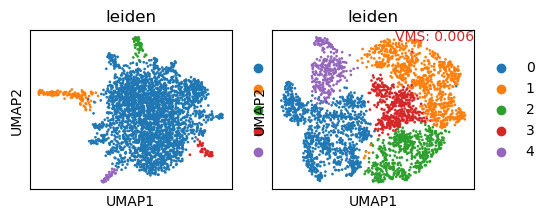

In [90]:
_ = plt.figure(figsize=(12, 12))
axe = plt.subplot(5, 4, 1)
sc.pl.umap(md_histones, size=15, ax=axe, color="leiden", show=False)
axe = plt.subplot(5, 4, 2)
if wnn:
    sc.pl.umap(mdata, size=15, ax=axe, color='leiden_wnn', show=False)
else:
    sc.tl.umap(md_membrane, random_state=10)
    sc.pl.umap(md_membrane, size=15, ax=axe, color="leiden", show=False)
x = axe.get_xlim()[1]
y = axe.get_ylim()[1]
axe.text(x, y, f"VMS: {v_measures['leiden']:.3f}", va="top", ha="right", color="tab:red")
if wnn:
    axe = plt.subplot(5, 4, 3)
    mu.pl.embedding(mdata, basis="X_wnn_umap", color=["histone:leiden"], size=15, ax=axe, show=False)
    axe = plt.subplot(5, 4, 4)
    mu.pl.embedding(mdata, basis="X_wnn_umap", color="ADT:leiden", size=15, ax=axe, show=False)

 - Save Muon object and stats

Done.


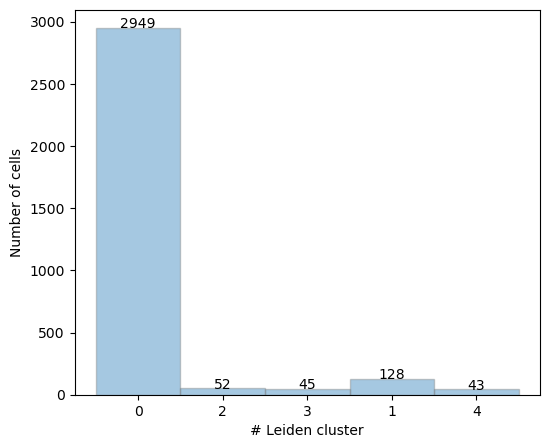

In [91]:
# for n, col in enumerate([c for c in adt_names if not c.endswith("IgD")]):
#     axe = plt.subplot(5, 4, n + 5)
#     sc.pl.umap(md_histones, size=15, ax=axe, color=col, show=False, color_map="Greys", vmin=-0.1, vmax=1.1)
#     x = axe.get_xlim()[1]
#     y = axe.get_ylim()[1]
#     axe.text(x, y, f"VMS: {v_measures[col]:.3f}", va="top", ha="right", color="tab:red")
# plt.tight_layout()
# plt.savefig(os.path.join(outdir, "UMAP_on_V-measures.png"))

# Leiden numbers
_ = plt.figure(figsize=(6, 5))
h = plt.hist(md_histones.obs["leiden"], bins=n_leiden, 
             range=(-0.5, n_leiden - 0.5), ec="tab:grey", alpha=0.4)
for y, x in zip(h[0], h[1]):
    plt.text(x + 0.5, y, int(y), ha="center")
plt.ylabel("Number of cells")
plt.xlabel("# Leiden cluster")
plt.savefig(os.path.join(outdir, "Leiden_plot.png"))

out = open(os.path.join(outdir, "stats.tsv"), "w")
line = "\t".join(str(v) for v in h[0])
out.write(f"COUNT\t{line}\n")
out.write(f"TOTAL\t{sum(h[0])}\n")
out.write(f"STDEV\t{np.std(h[0])}\n")
out.close()

# save Muon object
print(f" - Save Muon object and stats")    
mdata.write_h5mu(os.path.join(outdir, f"{sampleID}.h5mu"))

# compute jaccard index
M1 = mdata['histone'].obsp['connectivities']
M2 = mdata['ADT'].obsp['connectivities']

stat1 = jacind(M1, M2)
stat2 = jacind(M1, M2, binarize=True, p=1)

out = open(os.path.join(outdir, f"{sampleID}_stats.tsv"), "w")
out.write(f"VMS\t{vms}\n")
out.write(f"ARI\t{ari}\n")
out.write(f"JAC1\t{stat1}\n")
out.write(f"JAC2\t{stat2}\n")
out.close()


print(f"\nDone.")

In [92]:
###########################################################################
# cells_clusters.csv
if wnn:
    mdata.obs[["histone:leiden","ADT:leiden","leiden_wnn"]].to_csv(os.path.join(outdir, "cells_clusters.csv"))
else:
    mdata.obs[["histone:leiden","ADT:leiden"]].to_csv(os.path.join(outdir, "cells_clusters.csv"))